In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import os
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

Hello!!
I've build the pipeline and did the feature engineering part, but I didn't optimize the model.
If you're seeing this please use optimization techniques to optimize the model. 
-Manas


In [2]:
#Getting data
def get_power_data(lat, lon, start, end):
    
    BASE_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "AG",
        "parameters": "T2M_MAX,PRECTOTCORR,WS2M,RH2M",  
        "format": "JSON"
    }

    print(f"Requesting data for Lat: {lat}, Lon: {lon} from {start} to {end}...")

    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract data and handle potential missing values
    parameter_data = data['properties']['parameter']
    for param, values in parameter_data.items():
        for date, value in values.items():
            if value == -999:
                parameter_data[param][date] = None  # Replace -999 with None

    df = pd.DataFrame(parameter_data)
    df.index.name = 'Date'
    
    return df

def save_to_csv(dataframe, filename):
    if dataframe.empty:
        print("The DataFrame is empty. No file will be saved.")
        return

    if not filename.lower().endswith('.csv'):
        filename += '.csv'

    dataframe.to_csv(filename)
    
    full_path = os.path.abspath(filename)
    print(f"Data successfully saved to: {full_path}")

    return full_path

if __name__ == "__main__":

    LATITUDE = 21.1458       # Nagpur, India
    LONGITUDE = 79.0882
    START_DATE = "20220101"  # January 1, 2024
    END_DATE = "20221231"    # December 31, 2024
    OUTPUT_FILENAME = "weather_data"

    
    weather_df = get_power_data(LATITUDE, LONGITUDE, START_DATE, END_DATE)

    save_to_csv(weather_df, OUTPUT_FILENAME)

Requesting data for Lat: 21.1458, Lon: 79.0882 from 20220101 to 20221231...
Data successfully saved to: /kaggle/working/weather_data.csv


In [ ]:
df = pd.read_csv(save_to_csv(weather_df, OUTPUT_FILENAME))
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date', inplace=True)

In [ ]:
df.head()

In [ ]:
RAIN_THRESHOLD = 0.3 #in mm

In [ ]:
df['Did_Rain_Today'] = (df['PRECTOTCORR'] > RAIN_THRESHOLD).astype(int)

In [ ]:
# Feature Engineering

# Applying Lag and Rolling Windows

df['Will_Rain_Tomorrow'] = df['Did_Rain_Today'].shift(-1)

for lag in [1, 3, 7]:
    df[f'T2M_MAX_lag_{lag}'] = df['T2M_MAX'].shift(lag)
    df[f'RH2M_lag_{lag}'] = df['RH2M'].shift(lag)
    df[f'WS2M_lag_{lag}'] = df['WS2M'].shift(lag)

for window in [3, 7]:
    df[f'T2M_MAX_roll_mean_{window}'] = df['T2M_MAX'].rolling(window=window).mean()
    df[f'RH2M_roll_mean_{window}'] = df['RH2M'].rolling(window=window).mean()
    df[f'WS2M_roll_std_{window}'] = df['WS2M'].rolling(window=window).std()

df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month

df = df.drop('Did_Rain_Today', axis=1)
df = df.dropna()

In [ ]:
df['Will_Rain_Tomorrow'] = df.pop('Will_Rain_Tomorrow')
df.head()

In [ ]:
#model

features = [col for col in df.columns if col!='Will_Rain_Tomorrow']

X = df[features]
y = df['Will_Rain_Tomorrow']

split_index = int(len(df)*0.8) #used 20-80 (we can change accordingly)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nTraining on {len(X_train)} days, testing on {len(X_test)} days.")

model = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

# Print and visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Display feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importances')
plt.show()

This is the new model I'm making 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

In [11]:
LATITUDE = 21.1458       # Nagpur, India
LONGITUDE = 79.0882
START_DATE = "20080101"  
END_DATE = "20221231"
OUTPUT_FILENAME = "weather_data.csv"
RAIN_THRESHOLD = 0.3 #in mm

In [12]:
#Getting data
def get_power_data(lat, lon, start, end):
    
    BASE_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "AG",
        "parameters": "T2M_MAX,PRECTOTCORR,WS2M,RH2M",  
        "format": "JSON"
    }

    print(f"Requesting data for Lat: {lat}, Lon: {lon} from {start} to {end}...")

    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract data and handle potential missing values
    parameter_data = data['properties']['parameter']
    for param, values in parameter_data.items():
        for date, value in values.items():
            if value == -999:
                parameter_data[param][date] = None  # Replace -999 with None

    df = pd.DataFrame(parameter_data)
    df.index.name = 'Date'
    
    return df

def save_to_csv(dataframe, filename):
    if dataframe.empty:
        print("The DataFrame is empty. No file will be saved.")
        return

    if not filename.lower().endswith('.csv'):
        filename += '.csv'

    dataframe.to_csv(filename)
    
    full_path = os.path.abspath(filename)
    print(f"Data successfully saved to: {full_path}")

    return full_path

In [13]:
df = pd.read_csv(save_to_csv(weather_df, OUTPUT_FILENAME))
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date', inplace=True)

Data successfully saved to: /kaggle/working/weather_data.csv


In [14]:
df.head()

,T2M_MAX,PRECTOTCORR,WS2M,RH2M
Date,,,,
2008-01-01,30.19,0.00,1.88,44.08
2008-01-02,30.11,1.25,2.17,43.86
2008-01-03,29.87,0.03,1.78,42.34
2008-01-04,30.03,0.00,1.58,46.19
2008-01-05,30.18,0.00,1.55,52.43


In [15]:
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
 

    df['WS2M_KPH'] = df['WS2M'] * 3.6
    
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 366)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 366)
    
    df.set_index('Date', inplace=True)
    
    features = ['day_of_year', 'month', 'year', 'day_sin', 'day_cos']
    targets = ['T2M_MAX', 'PRECTOTCORR', 'WS2M_KPH', 'RH2M']
    
    df.dropna(subset=targets, inplace=True)
    X = df[features]
    y = df[targets]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
def train_climatological_model(csv_path):
    

    rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    model = MultiOutputRegressor(rf)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
       
    y_pred_df = pd.DataFrame(y_pred, columns=targets, index=y_test.index)
    
    maes = {}
    for target_name in targets:
        mae = mean_absolute_error(y_test[target_name], y_pred_df[target_name])
        maes[target_name] = mae
    
    return model, features, targets, maes

In [17]:
model, features, targets, maes = train_climatological_model("/kaggle/working/weather_data.csv")
for target, mae in maes.items():
    print(f"{target}: {mae:.2f}")

T2M_MAX: 0.84
PRECTOTCORR: 2.89
WS2M_KPH: 1.43
RH2M: 3.39


In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# Parameter grid for tuning
param_grid = {
    'estimator__n_estimators': [200, 500],
    'estimator__max_depth': [10, 15, 20],
    'estimator__min_samples_split': [5, 10, 15],
    'estimator__min_samples_leaf': [2, 4, 6],
    'estimator__max_features': ['sqrt', 'log2']
}
# Hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,  # MultiOutputRegressor
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=200; total time=   4.4s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500; total time=  10.9s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=   4.2s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=   4.1s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500; total time=  10.2s
[CV] END estimator__max_depth=10, estimator__max_features=s

GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=500,
                                                                            n_jobs=-1,
                                                                            random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [10, 15, 20],
                         'estimator__max_features': ['sqrt', 'log2'],
                         'estimator__min_samples_leaf': [2, 4, 6],
                         'estimator__min_samples_split': [5, 10, 15],
                         'estimator__n_estimators': [200, 500]},
             scoring='neg_mean_absolute_error', verbose=2)

In [19]:
# Best model
best_model = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

# Predict
y_pred = best_model.predict(X_test)

Best params: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 500}


In [35]:
cv_score = cross_val_score(best_model, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_score)
print("Mean cross-validation score: ", np.mean(cv_score))

Cross-validation scores:  [0.59059058 0.62205117 0.63505612 0.61029776 0.62692153]
Mean cross-validation score:  0.6169834337500799



# saving model 

In [36]:
import joblib
# save the model
joblib.dump(best_model, 'rainfall_prediction_model.pkl')

['rainfall_prediction_model.pkl']

In [55]:
def predict_future_weather(model, features, targets, future_date_str, lat, lon):
    try:
        future_date = pd.to_datetime(future_date_str)
    except ValueError:
        print("Invalid date format. Please use 'YYYY-MM-DD'.")
        return

    # Create base dataframe for prediction
    future_df = pd.DataFrame(index=[future_date])
    future_df['LAT'] = lat
    future_df['LON'] = lon

    # Add temporal (date-based) features
    future_df['day_of_year'] = future_df.index.dayofyear
    future_df['month'] = future_df.index.month
    future_df['year'] = future_df.index.year
    future_df['day_sin'] = np.sin(2 * np.pi * future_df['day_of_year'] / 366)
    future_df['day_cos'] = np.cos(2 * np.pi * future_df['day_of_year'] / 366)
    
    # Keep only the columns used for training
    missing_features = [f for f in features if f not in future_df.columns]
    for mf in missing_features:
        # Fill missing columns with a neutral default (e.g., 0)
        future_df[mf] = 0

    # Reorder columns to match training
    future_df = future_df[features]

    # Predict using the trained model
    predicted_values = model.predict(future_df)[0]
    
    forecast = {target: value for target, value in zip(targets, predicted_values)}
    
    # Define rain threshold if not global
    RAIN_THRESHOLD = 0.5  # mm, adjust as needed

    will_rain_prediction = "Yes" if forecast['PRECTOTCORR'] > RAIN_THRESHOLD else "No"
    
    # Print output nicely
    print(f"\n--- Climatological Forecast for {future_date_str} at (Lat: {lat}, Lon: {lon}) ---")
    print(f"  🌡️  Temperature (T2M_MAX): {forecast['T2M_MAX']:.2f} °C")
    print(f"  💧 Humidity (RH2M): {forecast['RH2M']:.2f} %")
    print(f"  🌧️ Rain Amount (PRECTOTCORR): {forecast['PRECTOTCORR']:.2f} mm")
    print(f"  🌬️ Wind Speed (WS2M_KPH): {forecast['WS2M_KPH']:.2f} km/hr")
    print(f"  ☔ Will it rain?: {will_rain_prediction}")


In [56]:
if __name__ == "__main__":
    print("\n--- Future Weather Forecaster ---")

    # Load your trained model
    # (skip this if your model is already in memory)
    # trained_model = joblib.load("trained_model.pkl")

    if trained_model:
        print("Model ready for predictions.")
        print("Enter a date in YYYY-MM-DD format and coordinates to get a forecast, or type 'quit' to exit.")

        while True:
            user_input = input("\nEnter date (YYYY-MM-DD): ")
            if user_input.lower() in ['quit', 'exit']:
                print("Exiting.")
                break

            try:
                latitude_input = float(input("Enter latitude: "))
                longitude_input = float(input("Enter longitude: "))

                predict_future_weather(
                    trained_model,
                    model_features,
                    model_targets,
                    user_input,          # Future date input by user
                    latitude_input,      # User-provided latitude
                    longitude_input      # User-provided longitude
                )
            except ValueError:
                print("Please enter valid numeric values for latitude and longitude.")
            except Exception as e:
                print(f"Error: {e}")



--- Future Weather Forecaster ---
Model ready for predictions.
Enter a date in YYYY-MM-DD format and coordinates to get a forecast, or type 'quit' to exit.



Enter date (YYYY-MM-DD):  2025-10-05
Enter latitude:  23.7957
Enter longitude:  86.4304



--- Climatological Forecast for 2025-10-05 at (Lat: 23.7957, Lon: 86.4304) ---
  🌡️  Temperature (T2M_MAX): 29.84 °C
  💧 Humidity (RH2M): 86.86 %
  🌧️ Rain Amount (PRECTOTCORR): 2.81 mm
  🌬️ Wind Speed (WS2M_KPH): 6.76 km/hr
  ☔ Will it rain?: Yes



Enter date (YYYY-MM-DD):  2025-10-05
Enter latitude:  16.3067
Enter longitude:  80.4365



--- Climatological Forecast for 2025-10-05 at (Lat: 16.3067, Lon: 80.4365) ---
  🌡️  Temperature (T2M_MAX): 29.84 °C
  💧 Humidity (RH2M): 86.86 %
  🌧️ Rain Amount (PRECTOTCORR): 2.81 mm
  🌬️ Wind Speed (WS2M_KPH): 6.76 km/hr
  ☔ Will it rain?: Yes



Enter date (YYYY-MM-DD):  2025-10-04
Enter latitude:  16.3067
Enter longitude:  80.4365



--- Climatological Forecast for 2025-10-04 at (Lat: 16.3067, Lon: 80.4365) ---
  🌡️  Temperature (T2M_MAX): 29.73 °C
  💧 Humidity (RH2M): 86.14 %
  🌧️ Rain Amount (PRECTOTCORR): 0.72 mm
  🌬️ Wind Speed (WS2M_KPH): 6.23 km/hr
  ☔ Will it rain?: Yes



Enter date (YYYY-MM-DD):  exit


Exiting.


In [41]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

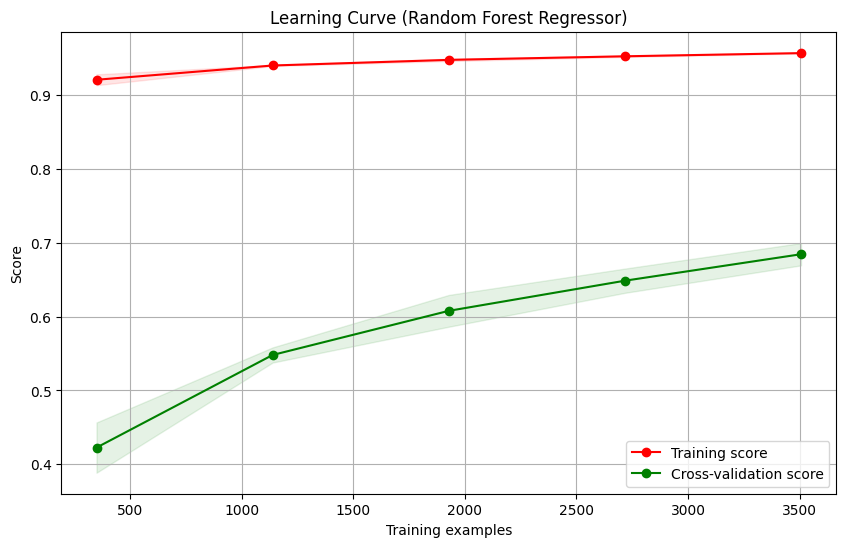

In [42]:
plot_learning_curve(model, X_train, y_train, title="Learning Curve (Random Forest Regressor)")
plt.show()

#plot_learning_curve(clf_model, X_train_clf, y_train_clf, title="Learning Curve (Random Forest Classifier)")
#plt.show()